# Term Paper

Submission for implementation of two models from the paper:

Song M, Takahashi YK, Burton AC,
Roesch MR, Schoenbaum G, Niv Y, et al. (2022)
Minimal cross-trial generalization in learning the
representation of an odor-guided choice task. PLoS
Comput Biol 18(3): e1009897. https://doi.org/10.1371/journal.pcbi.100989

By the group: 

Lokendra Kumar Meena - 180383

Palashdeep Singh - 180495

Aysuh Anand - 200238

<br><br>
Use the following account to mount the drive, all data has been uploaded on the drive

Username - cs786project@gmail.com

Password - iitk@123

In [1]:
#Importing important libraries
import os
import sys
import pystan
import pickle
import numpy as np
import pandas as pd
import scipy as sp
from hashlib import md5
import seaborn as sns
from math import isnan
from math import isinf
from __future__ import division
import scipy.stats.kde as kde
from scipy.special import expit
from google.colab import drive
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Declarations

In [3]:
# Simulation info Global Parameters 
sim_blocks = 4
sim_trials = 16
sim_sessions = 2

In [4]:
samples = 2000 # samples per chain
warmup = 1500 # warmup samples
chains = 4 # number of chains
thin = 1 # period for saving samples
n_jobs = 4 # cores
n_blocks = 4 # blocks in experiment

samplingInfo = dict(samples=samples, warmup=warmup, chains=chains, thin=thin, n_jobs=n_jobs)

In [5]:
# Dataset handling with 3 differnet datasets available
datasets = ['roesch2009', 'takahashi2016', 'burton2018']

dataset2marker = {
    'roesch2009': '+',
    'takahashi2016': '.',
    'burton2018': 'x'
}

ratio_s = {
    'roesch2009': 4/3,
    'takahashi2016': 5/3,
    'burton2018': 1
}

dataset_labels = {
    'roesch2009': 'Roesch et al. (2009)',
    'takahashi2016': 'Takahashi et al. (2016)',
    'burton2018': 'Burton et al. (2018)'
}

dataset2rat = {
    'roesch2009': [1,2,3,4,5,6,7,8,9],
    'takahashi2016': [10,11,12,13,14,15,16],
    'burton2018': [17,18,19,20,21,22]
}

In [6]:
rat2dataset = dict()
for i in range(1,23):
    if 1 <= i <= 9:
        rat2dataset[i] = 'takahashi2016'
    elif 10 <= i <= 16:
        rat2dataset[i] = 'roesch2009'
    else:
        rat2dataset[i] = 'burton2018'

ratOrder = np.array([10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8, 9, 17, 18, 19, 20, 21, 22]) - 1

In [7]:
#Parameters for two of the models that we tried to implement
modelInfo = {
    'sixState_full': {
        'modelName': 'sixState_full',
        'parNames': ['beta','eta','gamma','sb','pers','lapse'],
        'Npars': 6,
        'parBounds': [[0,10], [0,1], [0,1], [-2,2], [-2,2], [0,1]]
    },
    'fourState_full': {
        'modelName': 'fourState_full',
        'parNames': ['beta','eta','gamma','sb','pers','lapse'],
        'Npars': 6,
        'parBounds': [[0,10], [0,1], [0,1], [-2,2], [-2,2], [0,1]]
    },
}

## Helper functions

In [8]:
def phi_approx(x): # Phi_approx(x) = logit^{-1}(0.07056 x^3 + 1.5976 x)
    return expit(0.07056*(x**3) + 1.5976*x)

In [9]:
#This is combined function of above two with code changed but same logic
def Parameter_processing(datasetName, modelName):
    data = pd.read_csv('/content/drive/My Drive/model_fits/' + datasetName + '_' + modelName + '_allSamples.csv')
    params = np.empty((modelInfo[modelName]['Nparams']))
    for iPar, parName in enumerate(modelInfo[modelName]['parNames']):
        params[iPar] = data.loc[data['warmup']==0, 'params[' + str(iPar+1) + ']'].values.mean()

    #transforming the parameters
    params_trans = expit(0.07056*(params**3) + 1.5976*params)
    params_trans = params_trans[0]*10
    params_trans[4] = params_trans[4]*4-2
    params_trans[3] = params_trans[3]*4-2

    return params_trans

## Model

In [14]:
# Function for converting data to dictionary
def data2dict(data):
    
    Ns = data['rat'].unique().size # N subjects
    Nt = data.shape[0] # total number of trials
    
    NSession = np.array([data.loc[data['rat']==rat,'session'].unique().size for rat in data['rat'].unique()]) #unique sessions
    NSessionTotal = np.sum(NSession)
    
    startSubject = np.concatenate(([1],data['rat'][1:].values!=data['rat'][:-1].values))
    startSession = np.concatenate(([1],data['session'][1:].values!=data['session'][:-1].values))
    
    block_index = data['block'].fillna(0).values.astype(int)
    
    # For the odor tasks
    odor = np.zeros(data.shape[0])
    odor[data['odor']=='left'] = 1
    odor[data['odor']=='right'] = 2
    odor[data['odor']=='free'] = 3
    odor = odor.astype(int)
    
    choice = data['choice'].fillna(0).values.astype(int)
    reward = data['rewardAmount'].fillna(0).values.astype(int)
    delay = data['rewardDelay'].fillna(0).values
    
    trialType = np.zeros(data.shape[0])
    trialType[data['trialType']=='valid'] = 1
    trialType[data['trialType']=='shortStay'] = -1
    trialType = trialType.astype(int)
    
    sessionType = np.zeros(data.shape[0])
    sessionType[data['sessionType']=='leftBetterFirst'] = 1
    sessionType[data['sessionType']=='rightBetterFirst'] = 2
    sessionType = sessionType.astype(int)
    return dict(Ns=Ns, Nt=Nt, NSession=NSession, NSessionTotal=NSessionTotal, odor=odor, choice=choice, reward=reward, delay=delay, trialType=trialType, sessionType=sessionType, startSubject=startSubject, startSession=startSession, block_index=block_index)


In [15]:
# Function for caching models
def compile_model(filename, model_name=None, **kwargs):
    # Stan models for parameter defenition uploaded on drive
    with open(filename) as f:
        model_code = f.read()
        code_hash = md5(model_code.encode('ascii')).hexdigest()
        
        if model_name is None:
            cache_fn = 'cached-model-{}.pkl'.format(code_hash)
        else:
            cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
        try:
            sm = pickle.load(open(cache_fn, 'rb'))
        except:
            sm = pystan.StanModel(model_code=model_code)
            with open(cache_fn, 'wb') as f:
                pickle.dump(sm, f)
        else:
            print("Using cached StanModel")
        return sm

In [16]:
# compiling the model using stan_utility for model definiton
def fitModel(modelName, datasetName, dd=None, samplingInfo=None):
    
    #compiles the first time, saves the cached model and reuses it if there's no change
    stanFile = '/content/drive/My Drive/model_code_stan/' + modelName + '.stan'
    model = compile_model(stanFile)
    
    # fit model
    fit = model.sampling(data=dd, iter=samplingInfo['samples'], warmup=samplingInfo['warmup'], n_jobs=samplingInfo['n_jobs'], chains=samplingInfo['chains'], seed=0, init='random')
    
    # save the fit to csv
    allSamples = fit.to_dataframe(permuted=False, inc_warmup=True)
    allSamples.to_csv('/content/drive/My Drive/model_fits/'+datasetName+'_'+modelName+'_allSamples.csv')
    
    return fit

In [17]:
datasetName = 'takahashi2016roesch2009burton2018Valid'
modelName = 'sixState_full'  # alternatively: 'fourState_full'

# import data
data = pd.read_csv('/content/drive/My Drive/' + datasetName + '.csv')
dd = data2dict(data)

In [ ]:

# fit model and save
fit = fitModel(modelName, datasetName, dd, samplingInfo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_270956cc540b0fdc34127b71223c72da NOW.


## Learning Curve Plotting

In [18]:
def getFirstLastNTrials(N, sessionData, trialType, rewardType=None):    
    first = sessionData.head(N).reset_index(drop=True).copy()
    last = sessionData.tail(N).reset_index(drop=True).copy()
    if rewardType is None:
        first.loc[(((first['odor']=='left')|(first['odor']=='right')) if trialType=='free' else first['odor']=='free'), 'correct'] = np.nan
        last.loc[((last['odor']=='left')|(last['odor']=='right') if trialType=='free' else last['odor']=='free'), 'correct'] = np.nan
    else:
        first.loc[((first['odor']=='left')|(first['odor']=='right') if trialType=='free' else first['odor']=='free') & (first['rewardType']==1 if rewardType == 'highR' else first['rewardType']==2), 'correct'] = np.nan
        last.loc[((last['odor']=='left')|(last['odor']=='right') if trialType=='free' else last['odor']=='free') & (last['rewardType']==1 if rewardType == 'highR' else last['rewardType']==2), 'correct'] = np.nan
    return (filltoNtrials(N, first['correct'].values, -1), filltoNtrials(N, last['correct'].values, 0))

In [11]:
def filltoNtrials(N, tmp, loc):
    if loc == -1:
        if tmp.size<N:
            for i in range(N-tmp.size):
                tmp = np.append(tmp, np.nan)
    elif loc == 0:
        if tmp.size<N:
            for i in range(N-tmp.size):
                tmp = np.insert(tmp, 0, np.nan)
                np.append(tmp,[np.nan])
    return tmp

In [12]:
def plotLearningCurve(data, N=10, ifReturnCurveData=False, ifLegend=False):
    
    if ifReturnCurveData:
        curveData=dict()
        for trialType in ['forced','free']:
          for dataName in ['x','y','err']:
            curveData[(trialType, dataName)]=None
    else:
        # plot setting
        from IPython.display import set_matplotlib_formats
        set_matplotlib_formats('png', 'pdf')
        plt.rcParams.update({'font.family': 'arial'})
        lineWidth = 2
        fig, ax = plt.subplots(figsize=(10,3.5))
    
    # create x variable (trial index)
    trialIndices = []
    for i_block in range(n_blocks*2):
        if i_block == 0:
            start = 1
        else:
            start = trialIndices[-2] + (2 if i_block%2 else 1)
        trialIndices = np.concatenate((trialIndices, np.arange(start, start+N), [np.nan]))   
    
    # note that the correct choice for free trials is defined based on block type (which is defined based on detected block change point, can be later than real change point)
    data['correctChoice'] = 1*(data['odor']=='left') + 2*(data['odor']=='right') + (data['odor']=='free')*(
            1*((data['blockType']=='short_long')|(data['blockType']=='big_small')) +
            2*((data['blockType']=='long_short')|(data['blockType']=='small_big')) )
    data['correct'] = (data['correctChoice'] == data['choice'])
    
    for trialType in ['forced','free']:
        learningCurves = []
        for iRat, rat in enumerate(data['rat'].unique()):
            learningCurve = []
            for i_block in np.arange(n_blocks)+1:
                sessions = data.loc[data['rat']==rat,'session'].unique()
                NSessions = sessions.shape[0]
                firstN = np.zeros((NSessions, N))
                lastN = np.zeros((NSessions, N))
                for iter_session in range(NSessions):
                    sessionData = data[(data['rat']==rat) & (data['block']==i_block) & (data['session']==sessions[iter_session]) & (data['trialType']=='valid')]
                    thisFirst, thisLast = getFirstLastNTrials(N, sessionData, trialType)
                    firstN[iter_session, :] = thisFirst
                    lastN[iter_session, :] = thisLast
                if NSessions > 1:
                    learningCurve.append(np.nanmean(firstN, axis=0))
                    learningCurve.append(np.nanmean(lastN, axis=0))
                else:
                    learningCurve.append(firstN[0, :])
                    learningCurve.append(lastN[0, :])
            learningCurves.append(np.concatenate([np.concatenate((curve,[np.nan])) for curve in learningCurve]))
            
        NValidRat = np.sum(~np.isnan(np.stack(learningCurves)), axis=0)
        y = np.nanmean(learningCurves, axis=0)
        err = np.nanstd(learningCurves, axis=0)/np.sqrt(NValidRat)
        if ifReturnCurveData:
            curveData[trialType, 'x'] = trialIndices
            curveData[trialType, 'y'] = y
            curveData[trialType, 'err'] = err
        else:
            ax.plot(trialIndices, y, 'r' if trialType=='forced' else 'b', label='Forced' if trialType=='forced' else 'Free', linewidth=lineWidth)
            ax.fill_between(trialIndices, y-err, y+err, color='r' if trialType=='forced' else 'b', alpha=0.3)

    if ifReturnCurveData:                                                  
        return curveData                                             #can change return to print and remove else condition
    else:
        # plot the block switch points and general figure settings
        for blockChange in np.array([N*2+1, N*4+2, N*6+3])+0.5:
            ax.axvline(x=blockChange, linestyle='--', color='gray', linewidth=lineWidth)
        ax.set_ylim([0, 1])
        ax.set_xlim([0, N*8+4])
        ax.set_xlabel('Trial')
        ax.set_ylabel('Accuracy')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticklabels('')
        ax.tick_params(axis='x', length=0)
        ax.set_xlabel('')
        ax.tick_params(axis='y', width=1.5, pad=5, direction='out')
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=25)
        ax.yaxis.labelpad = 10
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        if ifLegend:
            ax.legend(loc='lower right', frameon=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
/usr/lo

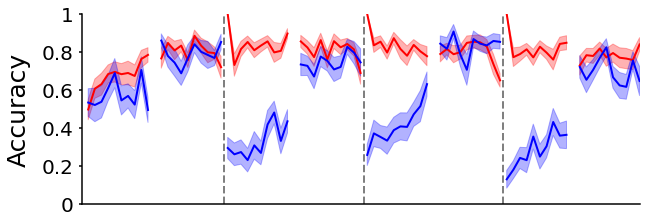

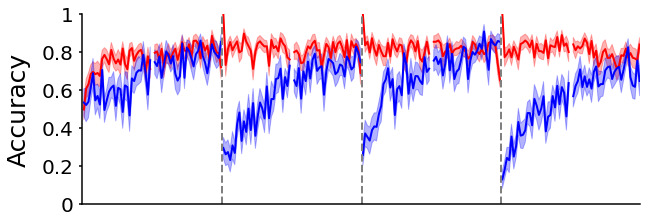

In [19]:
plotLearningCurve(data=data, N=10,ifLegend=False)
plotLearningCurve(data=data, N=30, ifLegend=False)

Learning curves for
forced-choice (red) and free-choice (blue) trials. The curves are aligned to block-switch points (gray dashed lines), with the first and last 10 trials of each
block shown. Accuracy is evaluated as the percentage of trials the animal chose the better option for that trial type (forced-choice trials: the rewarded
well; free-choice trials: the well with reward at shorter delay or larger amount). Shaded areas represent 1 s.e.m across animals.

## Run simulation / Load simulated data

In [20]:
# For Simulation
models = ['sixState_full', 'fourState_full']
dir_simu = '/content/drive/My Drive/model_simulation/'
datasetName = 'takahashi2016roesch2009burton2018Valid'

In [21]:
# simulation parameters
NSessions = 100000
NTrials = 57
w4List = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [22]:
from google.colab import drive
drive.mount("/content/drive/")
dataValid = pd.read_csv("/content/drive/My Drive/takahashi2016roesch2009burton2018Valid.csv")
ratList = dataValid['rat'].unique()
dataValid

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,dataset,rat,session,sessionType,trial,block,blockType,odor,choice,rewardAmount,rewardDelay,trialType,trialCondCode,trialCond,odorEntryRT,odorExitRT,wellEntryRT,wellExitRT
0,takahashi2016,1,1,leftBetterFirst,4,1,short_long,left,1,1,0.502000,valid,5.0,short_left,4.566050,0.776025,0.329050,3.814075
1,takahashi2016,1,1,leftBetterFirst,6,1,short_long,left,1,1,0.502050,valid,5.0,short_left,0.543000,0.762025,0.399000,4.194075
2,takahashi2016,1,1,leftBetterFirst,8,1,short_long,right,1,0,NaN,valid,NaN,NaN,1.490075,0.797000,0.498050,0.000000
3,takahashi2016,1,1,leftBetterFirst,9,1,short_long,right,1,0,NaN,valid,NaN,NaN,1.122000,0.622050,0.108025,0.000000
4,takahashi2016,1,1,leftBetterFirst,12,1,short_long,right,2,1,1.002025,valid,8.0,long_right,1.243025,0.552975,0.610025,3.089100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89880,burton2018,22,39,leftBetterFirst,717,4,small_big,free,2,2,0.502025,valid,2.0,big_right,1.006025,0.544000,0.257025,4.148150
89881,burton2018,22,39,leftBetterFirst,719,4,small_big,left,1,1,0.501975,valid,3.0,small_left,2.716125,0.615000,0.335050,2.755100
89882,burton2018,22,39,leftBetterFirst,720,4,small_big,free,2,2,0.502000,valid,2.0,big_right,3.059100,0.584000,0.263025,4.141175
89883,burton2018,22,39,leftBetterFirst,721,4,small_big,free,2,2,0.502075,valid,2.0,big_right,5.154175,0.641000,0.251025,4.433100


In [23]:
def get_params(datasetName, modelName):
    allSamples = pd.read_csv('/content/drive/My Drive/model_fits/' + datasetName + '_' + modelName + '_allSamples.csv')
    mu_pr = np.empty((modelInfo[modelName]['Npars']))
    for iPar, parName in enumerate(modelInfo[modelName]['parNames']):
        mu_pr[iPar] = allSamples.loc[allSamples['warmup']==0, 'mu_pr[' + str(iPar+1) + ']'].values.mean()
    pars = transform_params(modelName, mu_pr)
    return pars

In [24]:
def transform_params(modelName, mu_pr):
    pars = phi_approx(mu_pr);
    pars[0] = pars[0] * 10;  # beta
    pars[3] = pars[3] * 4 - 2;
    pars[4] = pars[4] * 4 - 2;  
    return pars

In [25]:
#This is for the 126-143 lines of code in the parent file
def get_TrialConditionCode(choice, bType):
    if choice == 1:
        if bType == 'big_small':
            return 1
        elif bType == 'small_big':
            return 3
        elif bType == 'short_long':
            return 5
        elif bType == 'long_short':
            return 7
    else:
        if bType == 'big_small':
            return 4
        elif bType == 'small_big':
            return 2
        elif bType == 'short_long':
            return 8
        elif bType == 'long_short':
            return 6
    return -1

In [26]:
# Function to generate odor sequences
def generate_odorSeq():
    odorSeq = []
    while len(odorSeq) < sim_trials:
        newSeq = [1]*8 + [2]*8 + [3]*7
        np.random.shuffle(newSeq)
        newSeq = list(newSeq)
        if not (([1, 1, 1] in newSeq) or ([2, 2, 2] in newSeq) or ([3, 3, 3] in newSeq)):
            odorSeq = odorSeq + newSeq

    return odorSeq

In [27]:
def sixState_full_sim(params, iRat=1):
    beta, eta, gamma, sb, pers, lapse = params[0], params[1], params[2], params[3], params[4], params[5]
    # initialization
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList = [[] for _ in range(12)]

    for iSession in range(sim_sessions):
        # session info
        sessionType = np.random.choice(['leftBetterFirst', 'rightBetterFirst'])
        if sessionType == 'leftBetterFirst':
            blockTypeSeq = ['short_long', 'long_short', 'big_small', 'small_big']
        else:
            blockTypeSeq = ['long_short', 'short_long', 'small_big', 'big_small']

        # at the start of a new session, reset Q values and the perseveration term
        Q = np.zeros((3, 2));
        preChoice = 0;
        perseveration = np.zeros(2);

        for iBlock in range(sim_blocks):
            blockType = blockTypeSeq[iBlock]
            longDelay = 0
            freeChoices = []
            
            odorSeq = generate_odorSeq()

            iOdor = 0
            for iTrial in range(sim_trials):
            
                # trial info
                odor = odorSeq[iOdor]

                # decision variable of left and right choices
                if preChoice > 0:  # not the first choice of a session
                    perseveration[preChoice-1] = pers;
                    perseveration[2-preChoice] = 0;
                
                DVLeft = Q[odor-1, 0] + perseveration[0]
                DVRight = Q[odor-1, 1] + sb + perseveration[1]

                # simulate choice
                pLeft = (1 - lapse) * 1 / (1 + np.exp(- beta * (DVLeft - DVRight))) + lapse/2
                choice = 2 - (np.random.random() < pLeft)
                if odor == 3:
                    freeChoices.append(choice)

                # simulate reward
                ifReward = (odor == choice) + (odor == 3)
                if ifReward:
                    # reward amount
                    if (blockType in ['short_long', 'long_short']) or (blockType == 'small_big' and choice == 1) or (blockType == 'big_small' and choice == 2):
                        reward = 1
                    else:
                        reward = 2
                    # reward delay
                    if (blockType == 'long_short' and choice == 1) or (blockType == 'short_long' and choice == 2): # if choosing the long reward side
                        longDelay = longDelay + 1
                        if longDelay > 7:
                            longDelay = 7
                        delay = longDelay
                    else:
                        delay = 0.5
                    # trial condition code
                    trialCondCode = get_TrialConditionCode(choice, blockType)
                    
                    # discounted reward
                    rewardPerceived = reward * np.power(gamma, delay)
                else:
                    reward = 0
                    delay = np.nan
                    trialCondCode = np.nan
                    rewardPerceived = 0
                
                # in timing blocks, reduce longDelay by 1s if chosen less than 8 times in the last 10 free choice trials, to a minimum of 3s
                if (blockType in ['short_long', 'long_short']) and (longDelay > 3):
                    choiceLong = 1 if blockType == 'long_short' else 2
                    if (len(freeChoices) >= 10) and (len(np.where(np.array(freeChoices[-10:]) == choiceLong)[0]) < 8):
                        longDelay = longDelay - 1

                delta = rewardPerceived - Q[odor-1, choice-1]
                Q[odor-1, choice-1] += eta * delta

                # update the previous choice
                preChoice = choice;
                
                # record data
                sessionList.append(iSession+1)
                sessionTypeList.append(sessionType)
                trialList.append(iTrial+1)
                blockList.append(iBlock+1)
                blockTypeList.append(blockType)
                odorList.append('left' if odor==1 else ('right' if odor==2 else 'free'))
                choiceList.append(choice)
                rewardAmountList.append(reward)
                rewardDelayList.append(delay)
                trialTypeList.append('valid')
                trialCondCodeList.append(trialCondCode)
                
                # proceed to the next trial
                if not ((odor < 3) and (choice != odor)): # if correct forced choice or any free choice
                    iOdor += 1
    
    trialCondMapping = ['big_left','big_right','small_left','small_right','short_left','short_right','long_left','long_right']
    trialCondList = [np.nan if np.isnan(trialCondCode) else trialCondMapping[trialCondCode - 1] for trialCondCode in trialCondCodeList]
    dataset = ['simulation'] * len(sessionList)
    rat = [iRat] * len(sessionList)
    data = pd.DataFrame(list(zip(dataset, rat, sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList)), columns=['dataset', 'rat', 'session', 'sessionType', 'trial', 'block', 'blockType', 'odor', 'choice', 'rewardAmount', 'rewardDelay', 'trialType', 'trialCondCode', 'trialCond'])
    
    return data        

In [28]:
def fourState_full_sim(params, iRat=1):
    beta, eta, gamma, sb, pers, lapse = params[0], params[1], params[2], params[3], params[4], params[5]
    # initialization
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList = [[] for _ in range(12)]

    for iSession in range(sim_sessions):
        # session info
        sessionType = np.random.choice(['leftBetterFirst', 'rightBetterFirst'])
        if sessionType == 'leftBetterFirst':
            blockTypeSeq = ['short_long', 'long_short', 'big_small', 'small_big']
        else:
            blockTypeSeq = ['long_short', 'short_long', 'small_big', 'big_small']

        # at the start of a new session, reset Q values and the perseveration term
        Q = np.zeros(4);
        preChoice = 0;
        perseveration = np.zeros(2);

        for iBlock in range(sim_blocks):
            blockType = blockTypeSeq[iBlock]
            longDelay = 0
            freeChoices = []
            
            odorSeq = generate_odorSeq()

            iOdor = 0
            for iTrial in range(sim_trials):
            
                # trial info
                odor = odorSeq[iOdor]

                # decision variable of left and right choices
                if preChoice > 0:  # not the first choice of a session
                    perseveration[preChoice-1] = pers;
                    perseveration[2-preChoice] = 0;
                
                DVLeft = Q[odorchoice2state[odor-1,0]-1] + perseveration[0]
                DVRight = Q[odorchoice2state[odor-1,1]-1] + sb + perseveration[1]

                # simulate choice
                pLeft = (1 - lapse) * 1 / (1 + np.exp(- beta * (DVLeft - DVRight))) + lapse/2
                choice = 2 - (np.random.random() < pLeft)
                if odor == 3:
                    freeChoices.append(choice)

                # simulate reward
                ifReward = (odor == choice) + (odor == 3)
                if ifReward:
                    # reward amount
                    if (blockType in ['short_long', 'long_short']) or (blockType == 'small_big' and choice == 1) or (blockType == 'big_small' and choice == 2):
                        reward = 1
                    else:
                        reward = 2
                    # reward delay
                    if (blockType == 'long_short' and choice == 1) or (blockType == 'short_long' and choice == 2): # if choosing the long reward side
                        longDelay = longDelay + 1
                        if longDelay > 7:
                            longDelay = 7
                        delay = longDelay
                    else:
                        delay = 0.5
                    # trial condition code
                    trialCondCode = get_TrialConditionCode(choice, blockType)
                    
                    # discounted reward
                    rewardPerceived = reward * np.power(gamma, delay)
                else:
                    reward = 0
                    delay = np.nan
                    trialCondCode = np.nan
                    rewardPerceived = 0
                
                # in timing blocks, reduce longDelay by 1s if chosen less than 8 times in the last 10 free choice trials, to a minimum of 3s
                if (blockType in ['short_long', 'long_short']) and (longDelay > 3):
                    choiceLong = 1 if blockType == 'long_short' else 2
                    if (len(freeChoices) >= 10) and (len(np.where(np.array(freeChoices[-10:]) == choiceLong)[0]) < 8):
                        longDelay = longDelay - 1

                delta = rewardPerceived - Q[odorchoice2state[odor-1, choice-1] - 1]
                Q[odorchoice2state[odor-1, choice-1] - 1] += eta * delta
                
                # update the previous choice
                preChoice = choice;
                
                # record data
                sessionList.append(iSession+1)
                sessionTypeList.append(sessionType)
                trialList.append(iTrial+1)
                blockList.append(iBlock+1)
                blockTypeList.append(blockType)
                odorList.append('left' if odor==1 else ('right' if odor==2 else 'free'))
                choiceList.append(choice)
                rewardAmountList.append(reward)
                rewardDelayList.append(delay)
                trialTypeList.append('valid')
                trialCondCodeList.append(trialCondCode)
                
                # proceed to the next trial
                if not ((odor < 3) and (choice != odor)): # if correct forced choice or any free choice
                    iOdor += 1
    
    trialCondMapping = ['big_left','big_right','small_left','small_right','short_left','short_right','long_left','long_right']
    trialCondList = [np.nan if np.isnan(trialCondCode) else trialCondMapping[trialCondCode - 1] for trialCondCode in trialCondCodeList]
    dataset = ['simulation'] * len(sessionList)
    rat = [iRat] * len(sessionList)
    data = pd.DataFrame(list(zip(dataset, rat, sessionList, sessionTypeList, trialList, blockList, blockTypeList, odorList, choiceList, rewardAmountList, rewardDelayList, trialTypeList, trialCondCodeList, trialCondList)), columns=['dataset', 'rat', 'session', 'sessionType', 'trial', 'block', 'blockType', 'odor', 'choice', 'rewardAmount', 'rewardDelay', 'trialType', 'trialCondCode', 'trialCond'])
    
    return data        

In [29]:
def get_simulated_data(varName, modelName, w4=None, NSessions=10000, run_simulation=False):
    
    fileName = dir_simu + modelName + '_' + datasetName + '_groupMean' + (('_w4' + str(w4)) if w4 is not None else '') + '_NSessions' + str(NSessions) + '_NTrials' + str(NTrials) + '_' + varName + '.pickle'
    
    if varName == 'curveData':
        curveData = None
    
    if run_simulation:
        # set parameter values
        params = get_params(datasetName, modelName)
        if w4 is not None:
            params[1] = w4
        # run simulation
        if modelName=='sixState_full':
          dataSimu = sixState_full_sim(params)
        elif modelName=='fourState_full':
          dataSimu = fourState_full_sim(params)
        if varName == 'avgR':
            # calculate average reward
            value = dataSimu['rewardAmount'].mean()
        elif varName == 'curveData':
            # prepare data for plotting learning curve
            value = plotLearningCurve(dataSimu, N=10, ifReturnCurveData=True)
        # save results
        pickle.dump(value, open(fileName, 'wb'))
    else:
        # load results
        value = pickle.load(open(fileName, 'rb'))
        
    return value

In [30]:
run_simulation = True

avgR = dict.fromkeys(['rat'+str(rat) for rat in ratList] + models + ['w4'+str(w4) for w4 in w4List])

# all models
for modelName in models:
    avgR[modelName] = get_simulated_data('avgR', modelName, None, NSessions, run_simulation)

# animals
for rat in ratList:
    avgR['rat'+str(rat)] = dataValid.loc[dataValid['rat'] == rat, 'rewardAmount'].mean()

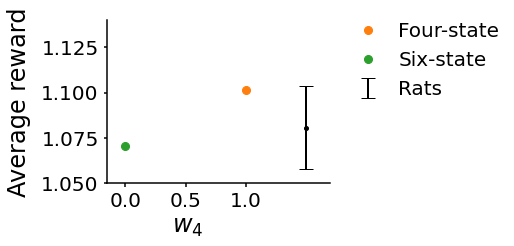

In [31]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

lineWidth = 2
fontsize = 24
labelsize = 20
ylim=[1.05, 1.14]

fig, ax = plt.subplots(figsize=(4,3))

# simulation
ax.plot(1, avgR['fourState_full'], 'o', color='C1', linewidth=lineWidth, markersize=8, label='Four-state')
ax.plot(0, avgR['sixState_full'], 'o', color='C2', linewidth=lineWidth, markersize=8, label='Six-state')

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection

N = 256
vals = np.ones((N, 2))
vals[:, 0] = np.linspace(44/256, 255/256, N)
vals[:, 1] = np.linspace(160/256, 127/256, N)

cmap = ListedColormap(vals)

# animals
avgR_rat = np.array([avgR['rat'+str(rat)] for rat in ratList])
ax.errorbar(x=1.5, y=np.mean(avgR_rat), yerr=np.std(avgR_rat)/np.sqrt(len(ratList)), linestyle='', color='k', capsize=7, linewidth=lineWidth, label='Rats')
ax.plot(1.5, np.mean(avgR_rat), '.', color='k', markersize=8)

ax.set_xlabel('$w_4$         ', fontsize=fontsize)
ax.set_ylabel('Average reward', fontsize=fontsize, labelpad=10)
ax.tick_params(axis='both', width=1.5, pad=5, direction='out', labelsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.set(xlim=[-0.15,1.7], ylim=ylim)
ax.set(xticks=[0,0.5,1])

ax.legend(frameon=False, fontsize=labelsize, handletextpad=0.5, bbox_to_anchor=(1, 1.1))

plt.show()

The four-state model (w 4 = 1) shows faster learning in each of
the blocks and higher asymptotic accuracy than the six-state model (w 4 = 0).

## Model Comparison

In [32]:
# For all models: samples is a dataframe with samples of parameters; dd is a data dictionary
def sixState_full_predict(samples, dd):
    
    # extract each parameter (beta, eta, gamma: #samples * #subjects)
    beta = np.array(samples.loc[:, ['beta['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    eta = np.array(samples.loc[:, ['eta['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    gamma =  np.array(samples.loc[:, ['gamma['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    sb =  np.array(samples.loc[:, ['sb['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    pers =  np.array(samples.loc[:, ['pers['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    lapse =  np.array(samples.loc[:, ['lapse['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    
    NSamples = samples.shape[0]
    
    likelihood = np.empty((NSamples, dd['Nt'])) * np.nan
    currentSubject = -1;
    currentSession = -1;
    
    # Likelihood of all the data
    for tr in np.arange(dd['Nt']):
        if dd['startSubject'][tr]>0: # if this is the start of a new subject
            currentSubject += 1;
        if dd['startSession'][tr]>0: # if this is the start of a new session
            currentSession += 1;
            # reset Q values and the perseveration term
            Q = np.zeros((NSamples, 3, 2));
            preChoice = 0;
            perseveration = np.zeros((NSamples, 2));
        if dd['trialType'][tr] != 0: # valid trials or early exit trials (trials with choices)
            if preChoice > 0:  # not the first choice of a session
                perseveration[:, preChoice-1] = pers[:, currentSubject];
                perseveration[:, 2-preChoice] = 0;
            # likelihood of observed choice
            DVLeft = Q[:, dd['odor'][tr]-1, 0] + perseveration[:, 0]
            DVRight = Q[:, dd['odor'][tr]-1, 1] + sb[:, currentSubject] + perseveration[:, 1]
            pLeft = (1 - lapse[:, currentSubject]) * 1 / (1 + np.exp(- beta[:, currentSubject] * (DVLeft - DVRight))) + lapse[:, currentSubject]/2
            likelihood[:, tr] = pLeft if dd['choice'][tr] == 1 else (1-pLeft)
            # calculate reward prediction error
            delta = dd['reward'][tr] * np.power(gamma[:, currentSubject], dd['delay'][tr]) - Q[:, dd['odor'][tr]-1, dd['choice'][tr]-1];
            # update Q values
            Q[:, dd['odor'][tr]-1, dd['choice'][tr]-1] += eta[:, currentSubject] * delta;
            # update the previous choice
            preChoice = dd['choice'][tr];
    
    return likelihood

In [33]:
def fourState_full_predict(samples, dd):
    
    # extract each parameter (beta, eta, gamma: #samples * #subjects)
    beta = np.array(samples.loc[:, ['beta['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    eta = np.array(samples.loc[:, ['eta['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    gamma =  np.array(samples.loc[:, ['gamma['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    sb =  np.array(samples.loc[:, ['sb['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    pers =  np.array(samples.loc[:, ['pers['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    lapse =  np.array(samples.loc[:, ['lapse['+str(iSub+1)+']' for iSub in np.arange(dd['Ns'])]])
    
    NSamples = samples.shape[0]
    
    odorchoice2state = np.array([[1,4],[3,2],[1,2]])
    
    likelihood = np.empty((NSamples, dd['Nt'])) * np.nan
    currentSubject = -1;
    currentSession = -1;
    
    # Likelihood of all the data
    for tr in np.arange(dd['Nt']):
        if dd['startSubject'][tr]>0: # if this is the start of a new subject
            currentSubject += 1;
        if dd['startSession'][tr]>0: # if this is the start of a new session
            currentSession += 1;
            # reset Q values and the perseveration term
            Q = np.zeros((NSamples, 4));
            preChoice = 0;
            perseveration = np.zeros((NSamples, 2));
        if dd['trialType'][tr] != 0: # valid trials or early exit trials (trials with choices)
            if preChoice > 0:  # not the first choice of a session
                perseveration[:, preChoice-1] = pers[:, currentSubject];
                perseveration[:, 2-preChoice] = 0;
            # likelihood of observed choice
            DVLeft = Q[:, odorchoice2state[dd['odor'][tr]-1,0] -1] + perseveration[:, 0]
            DVRight = Q[:, odorchoice2state[dd['odor'][tr]-1,1] -1] + sb[:, currentSubject] + perseveration[:, 1]
            pLeft = (1 - lapse[:, currentSubject]) * 1 / (1 + np.exp(- beta[:, currentSubject] * (DVLeft - DVRight))) + lapse[:, currentSubject]/2
            likelihood[:, tr] = pLeft if dd['choice'][tr] == 1 else (1-pLeft)
            # calculate reward prediction error
            delta = dd['reward'][tr] * np.power(gamma[:, currentSubject], dd['delay'][tr]) - Q[:, odorchoice2state[dd['odor'][tr]-1, dd['choice'][tr]-1] - 1 ];
            # update Q values
            Q[:, odorchoice2state[dd['odor'][tr]-1, dd['choice'][tr]-1] - 1 ] += eta[:, currentSubject] * delta;
            # update the previous choice
            preChoice = dd['choice'][tr];
    
    return likelihood

In [34]:
modelPredictions = {
    'sixState_full': sixState_full_predict,
    'fourState_full': fourState_full_predict,
}

In [35]:
def func_WAIC(likelihood, typeCorrection=2):
    
    # likelihood: #samples * #trials
    lppd = np.sum(np.log(np.mean(likelihood, axis=0)))
    if typeCorrection == 1:
        pWAIC = 2 * np.sum( np.log(np.mean(likelihood, axis=0)) - np.mean(np.log(likelihood), axis=0) )
    else:
        pWAIC = np.sum(np.var(np.log(likelihood), axis=0, ddof=1))
    return - 2 * lppd + 2 * pWAIC

In [36]:
def func_WAIC_comparison(likelihood1, likelihood2, typeCorrection=2):
    
    # likelihood1/2: #samples * #trials
    # take model 1 as baseline
    Ntrials = likelihood1.shape[1]
    
    lppd1_trial = np.log(np.mean(likelihood1, axis=0))
    lppd2_trial = np.log(np.mean(likelihood2, axis=0))
    if typeCorrection == 1:
        pWAIC1_trial = 2 * ( np.log(np.mean(likelihood1, axis=0)) - np.mean(np.log(likelihood1), axis=0) )
        pWAIC2_trial = 2 * ( np.log(np.mean(likelihood2, axis=0)) - np.mean(np.log(likelihood2), axis=0) )
    else:
        pWAIC1_trial = np.var(np.log(likelihood1), axis=0, ddof=1)
        pWAIC2_trial = np.var(np.log(likelihood2), axis=0, ddof=1)
    
    waic1_trial = - 2 * lppd1_trial + 2 * pWAIC1_trial
    waic2_trial = - 2 * lppd2_trial + 2 * pWAIC2_trial
    
    waic_diff = np.sum(waic2_trial - waic1_trial)
    waic_diff_se = np.sqrt(Ntrials * np.var(waic2_trial - waic1_trial))
    
    return waic_diff, waic_diff_se, waic_diff/Ntrials, waic_diff_se/Ntrials,

In [37]:
def calculate_likelihood(datasetName, data, baselineModel, modelList):
    
    # import data
    dd = data2dict(data)

    # get the likelihood for the baseline model
    allSamples_baseline = pd.read_csv('/content/drive/My Drive/model_fits/'+datasetName+'_'+baselineModel+'_allSamples.csv')
    parSamples_baseline = allSamples_baseline.loc[allSamples_baseline['warmup']==0, [col for col in allSamples_baseline if np.sum([col.startswith(parName+'[') for parName in modelInfo[baselineModel]['parNames']])>0]]
    likelihood_baseline = modelPredictions[baselineModel](parSamples_baseline, dd)

    # calculate waic difference
    waicDiff, waicDiff_se = [dict.fromkeys(modelList) for i in range(2)]
    waicDiff_rat_perTrial, waicDiff_rat_perTrial_se = [pd.DataFrame() for i in range(2)]

    for model in modelList:
        allSamples = pd.read_csv('/content/drive/My Drive/model_fits/'+datasetName+'_'+model+'_allSamples.csv')
        parSamples = allSamples.loc[allSamples['warmup']==0, [col for col in allSamples if np.sum([col.startswith(parName+'[') for parName in modelInfo[model]['parNames']])>0]]
        likelihood = modelPredictions[model](parSamples, dd)

        # for the entire group
        waicDiff[model], waicDiff_se[model], _, _ = func_WAIC_comparison(likelihood_baseline, likelihood, typeCorrection=2)

        # for each individual animal
        for rat in data['rat'].unique():
            _, _, diff_perTrial, se_perTrial = func_WAIC_comparison(likelihood_baseline[:, data['rat'] == rat], likelihood[:, data['rat'] == rat])
            waicDiff_rat_perTrial.loc[rat, model] = diff_perTrial
            waicDiff_rat_perTrial_se.loc[rat, model] = se_perTrial

    metrics_group = pd.DataFrame(data=[waicDiff, waicDiff_se], index=['waicDiff','waicDiff_se'])
    waicDiff_rat_perTrial = waicDiff_rat_perTrial.reset_index().rename(columns={'index':'rat'})
    waicDiff_rat_perTrial_se = waicDiff_rat_perTrial_se.reset_index().rename(columns={'index':'rat'})

    return metrics_group, waicDiff_rat_perTrial, waicDiff_rat_perTrial_se

,fourState_full,sixState_full
waicDiff,1211.398557,0.0
waicDiff_se,78.425047,0.0


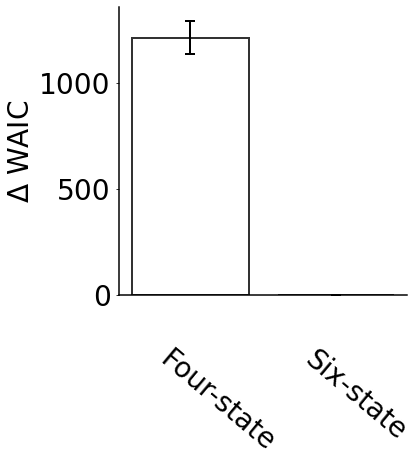

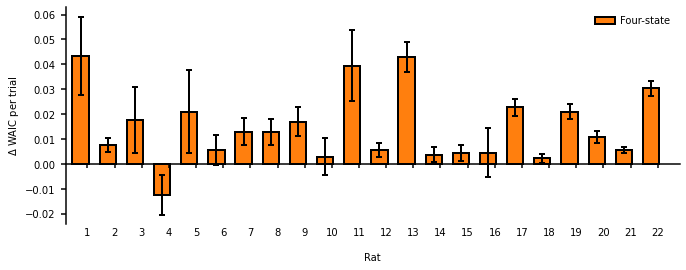

In [38]:
modelList = ['fourState_full', 'sixState_full']
baselineModel = 'sixState_full'
modelNames = {
    'sixState_full': 'Six-state',
    'fourState_full': 'Four-state',
    }

# Calculate WAIC difference from model fits (the following cell may take a few minutes to run)

metrics_group, waicDiff_rat_perTrial, waicDiff_rat_perTrial_se = calculate_likelihood(datasetName, data, baselineModel, modelList)

# Model comparison (WAIC) figure

colors_group = {
    'sixState_full':'w',
    'fourState_full':'w'
}

colors_individual = {
    'sixState_full': 'C2',
    'fourState_full': 'C1'
}

# for the entire group
fig, ax = plt.subplots(figsize=(4,4))
display(metrics_group[modelList])

iM = 0
for model in modelList:
    ax.bar(x=iM, height=metrics_group.loc['waicDiff', model], alpha=0.8, edgecolor='k', lineWidth=2, color=colors_group[model])
    ax.errorbar(x=iM, y=metrics_group.loc['waicDiff', model], yerr=metrics_group.loc['waicDiff_se', model], ecolor='k', fmt='None', capsize=5, label=None, elinewidth=2, markeredgewidth=2)
    iM += 1
ax.set_xticks(np.arange(len(modelList))-0.25)
ax.set_xlabel('', fontsize=28)
ax.set_ylabel(r'$\Delta$ WAIC', fontsize=28)
ax.tick_params(axis='both', pad=5, labelsize=28)
ax.tick_params(axis='x', length=0)
sns.despine()
ax.spines['bottom'].set_position('zero')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.tick_params(axis='x', pad=50)
ax.set_xticklabels([modelNames[model] for model in modelList], rotation=-40, horizontalalignment='left')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.show()


# per animal
fig, ax = plt.subplots(figsize=(5.5*(len(modelList)),4))
NRats = data['rat'].unique().size
x = np.arange(NRats)+1
deltax = np.linspace(0,1,len(modelList)-1)*0.5-0.25 #[-0.3, 0, 0.3]
barwidth = 0.2*3/(len(modelList)-1)
iM = 0
for model in modelList:
    waicDiff = waicDiff_rat_perTrial[model].values
    waicDiff_se = waicDiff_rat_perTrial_se[model].values
    if 'sixState' not in model:
        ax.bar(x+deltax[iM], height=[waicDiff[r] for r in ratOrder], width=barwidth, edgecolor='k', align='center', lineWidth=2, color=colors_individual[model], label=modelNames[model])
        ax.errorbar(x=x+deltax[iM], y=[waicDiff[r] for r in ratOrder], yerr=[waicDiff_se[r] for r in ratOrder], ecolor='k', fmt='None', capsize=3, label='', elinewidth=2, markeredgewidth=2)
        iM += 1
ax.set_xticks(x)
ax.set_xlabel('Rat')
ax.set_ylabel(r'$\Delta$ WAIC per trial')
ax.spines['bottom'].set_position('zero')
sns.despine()
ax.xaxis.labelpad = 15
ax.tick_params(axis='x', width=1.5, pad=15)
ax.tick_params(axis='x', pad=60)
ax.tick_params(axis='y', width=1.5, length=5, pad=5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.set(xlim=[0.2, NRats+0.8])
ax.legend(frameon=False, handletextpad=0.5, bbox_to_anchor=(1, 1))
plt.show()



Model comparison results.
WAIC difference between two models and the six-state model for the entire dataset (summed across all trials from all animals). Lower values indicate better
model fits. Error bars represent standard errors across samples . 



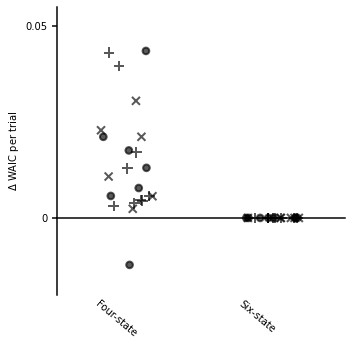

In [39]:
# jitterred scatter plot for individual delta WAIC per trial
waicdiff = pd.melt(waicDiff_rat_perTrial, id_vars=['rat'], value_vars=modelList, var_name='model', value_name='waicDiff_rat_perTrial')
fig, ax = plt.subplots(figsize=(4,4))
for dataset in datasets:
    sns.stripplot(x='model', y='waicDiff_rat_perTrial', data=waicdiff[waicdiff['rat'].isin(dataset2rat[dataset])], linewidth=2,
                  ax=ax, jitter=0.2, color='black', alpha=.65, size=8*ratio_s[dataset], marker=dataset2marker[dataset], label=dataset_labels[dataset])
sns.despine()
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_position('zero')
ax.tick_params(axis='x', length=0, width=1.5, pad=80)
ax.tick_params(axis='y', width=1.5, length=5, pad=5)
ax.set_xticks(np.arange(len(modelList))-0.25)
ax.set(yticks=[0, 0.05],yticklabels=[0,0.05])
ax.set_ylim([-0.02,0.055])
ax.set_xticklabels([modelNames[model] for model in modelList], rotation=-40, horizontalalignment='left')
ax.set_xlabel('')
ax.set_ylabel(r'$\Delta$ WAIC per trial')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.show()

Individual differences in average WAIC per trial between two models and the six-state model. Each marker corresponds to an individual animal, with different markers representing different datasets 